In [1]:
# Original dataset is downloaded from https://cims.nyu.edu/~sbowman/multinli/
# It is in form of txt file and has parse tree along with the data, 
# I am filtering these data to just have premise, hypothesis and Label.
# Using multiple negative ranking loss.
# Using https://sbert.net/datasets/stsbenchmark.tsv.gz for bench marking the model.

In [3]:
import csv
def map_MNLI_dataset_to_csv():
    DATASET_TXT = "multinli_1.0_train.txt"
    ORIGINAL_DATSET = "MultiNLI_datset.csv"
    HEADER = ['Premise', 'Hypothesis', 'Label']

    with open(DATASET_TXT, 'r') as fd:
        lines = fd.readlines()[1:]
        with open(ORIGINAL_DATSET, 'w', newline='') as fw:
            csv_writer = csv.writer(fw)
            csv_writer.writerow(HEADER)
            for line in lines:
                text = line.strip().split('\t')
                p, h, label = text[-5].strip(), text[-6].strip(), text[0].strip()
                csv_writer.writerow([p, h, label])

# map_MNLI_dataset_to_csv()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

MNLI_model_path = "MNLI_model"
os.chdir('/content/drive/MyDrive/Studies/NLP_PROJECT')

In [6]:
DATASET_COLUMNS_MNLI = ['Premise', 'Hypothesis', 'Label']
DATASET_ENCODING = "ISO-8859-1"
org_dataset = pd.read_csv('MultiNLI_datset.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS_MNLI, usecols=DATASET_COLUMNS_MNLI, header=None)
my_dataset = pd.read_csv('premise_hypo_dataset.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS_MNLI, usecols=DATASET_COLUMNS_MNLI, header=None)
# dataset = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS, usecols=[q1, q2, is_duplicate], header=Noneencoding=DATASET_ENCODING, names=DATASET_COLUMNS, usecols=['target', 'text'], header=None)

In [7]:
print(org_dataset.head(), my_dataset.head())

                                             Premise  ...       Label
0                                            Premise  ...       Label
1  Product and geography are what make cream skim...  ...     neutral
2  You lose the things to the following level if ...  ...  entailment
3  A member of my team will execute your orders w...  ...  entailment
4                  This information belongs to them.  ...  entailment

[5 rows x 3 columns]                                              Premise  ...       Label
0                                            Premise  ...       Label
1  A young girl in black shorts is doing yard wor...  ...  entailment
2  A woman is making a telephone call and gets in...  ...  entailment
3  While on a class field trip in the fall, two f...  ...     neutral
4  A man is shown speaking to the camera while be...  ...     neutral

[5 rows x 3 columns]


In [8]:
org_dataset = org_dataset.dropna()
org_dataset.isnull().sum()

Premise       0
Hypothesis    0
Label         0
dtype: int64

In [9]:
my_dataset = my_dataset.dropna()
my_dataset.isnull().sum()

Premise       0
Hypothesis    0
Label         0
dtype: int64

(392663, 3)


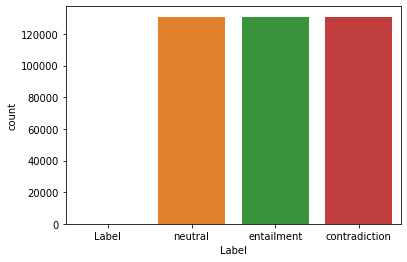

In [10]:
import seaborn as sns
sns.countplot(x='Label', data=org_dataset)
print(org_dataset.shape)

(20995, 3)


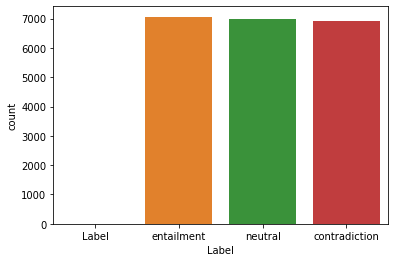

In [11]:
sns.countplot(x='Label', data=my_dataset)
print(my_dataset.shape)

In [12]:
print(org_dataset.shape)
org_dataset.info()
print(org_dataset.Label.unique())
print("\n"+"#"*80)
print(my_dataset.shape)
my_dataset.info()
print(my_dataset.Label.unique())

(392663, 3)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 392663 entries, 0 to 392702
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Premise     392663 non-null  object
 1   Hypothesis  392663 non-null  object
 2   Label       392663 non-null  object
dtypes: object(3)
memory usage: 22.0+ MB
['Label' 'neutral' 'entailment' 'contradiction']

################################################################################
(20995, 3)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20995 entries, 0 to 21525
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Premise     20995 non-null  object
 1   Hypothesis  20995 non-null  object
 2   Label       20995 non-null  object
dtypes: object(3)
memory usage: 1.3+ MB
['Label' 'entailment' 'neutral' 'contradiction']


In [13]:
# Skipping(headers)
org_dataset = org_dataset[1:]
my_dataset = my_dataset[1:]

In [14]:
# So the actual dataset size is ~400k and mine is 21k ~5% of the datset.
# Downsample original data to 20944, so both models are trained on same number of data.
from sklearn.model_selection import train_test_split
sampled_org_dataset, _ = train_test_split(org_dataset, train_size=20995, stratify=org_dataset['Label'])
train_org_dataset, validation_org_dataset = train_test_split(sampled_org_dataset, train_size=0.9, stratify=sampled_org_dataset['Label'])
train_my_dataset, _ = train_test_split(my_dataset, train_size=0.9, stratify=my_dataset['Label'])

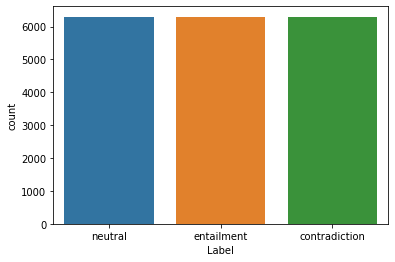

In [15]:
sns.countplot(x='Label', data=train_org_dataset)

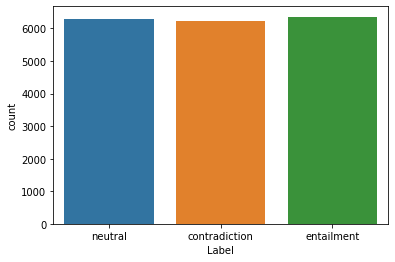

In [16]:
sns.countplot(x='Label', data=train_my_dataset)

In [17]:
train_org = "train_org.csv"
val_org = "val_org.csv"
train_my = "my_train.csv"
train_org_dataset.to_csv(os.path.join(MNLI_model_path, train_org))
train_my_dataset.to_csv(os.path.join(MNLI_model_path, train_my))
validation_org_dataset.to_csv(os.path.join(MNLI_model_path, val_org))

In [18]:
!pip install sentence-transformers

In [19]:
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation, datasets
from torch.utils.data import DataLoader
import csv

In [29]:
import gzip
train_batch_size = 64
margin = 0.5
num_epochs = 20

In [ ]:
org_model = SentenceTransformer('all-MiniLM-L12-v2')
train_samples = []
label_map = {"entailment":1, "contradiction":0}
with open(os.path.join(MNLI_model_path, train_org), 'r', newline='') as fr:
  csv_reader = csv.reader(fr)
  next(csv_reader)
  for _, s1, s2, label in csv_reader:
    if label == "entailment":
      train_samples.append(InputExample(texts=[s1, s2], label=1))
      train_samples.append(InputExample(texts=[s2, s1], label=1))
    elif label == "contradiction":
      train_samples.append(InputExample(texts=[s1, s2], label=0))
      train_samples.append(InputExample(texts=[s2, s1], label=0))

print(f'Training samples length: {len(train_samples)}')
random.shuffle(train_samples)
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)
train_loss = losses.MultipleNegativesRankingLoss(model=org_model)

#Read STSbenchmark dataset and use it as evaluator set
dev_samples = []
with gzip.open("stsbenchmark.tsv.gz", 'rt', encoding='utf8') as fIn:
    reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in reader:
        if row['split'] == 'dev':
            score = float(row['score']) / 5.0 #Normalize score to range 0 ... 1
            dev_samples.append(InputExample(texts=[row['sentence1'], row['sentence2']], label=score))

evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(dev_samples, batch_size=train_batch_size, name='org_org_eval')
org_model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=num_epochs,
          evaluation_steps=int(len(train_dataloader)*0.1),
          warmup_steps=1000,
          output_path=os.path.join(MNLI_model_path, "org_org_model"),
          )

In [ ]:
my_model = SentenceTransformer('all-MiniLM-L12-v2')
train_samples = []
label_map = {"entailment":1, "contradiction":0}
with open(os.path.join(MNLI_model_path, train_my), 'r', newline='') as fr:
  csv_reader = csv.reader(fr)
  next(csv_reader)
  for _, s1, s2, label in csv_reader:
    if label == "entailment":
      train_samples.append(InputExample(texts=[s1, s2], label=1))
      train_samples.append(InputExample(texts=[s2, s1], label=1))
    elif label == "contradiction":
      train_samples.append(InputExample(texts=[s1, s2], label=0))
      train_samples.append(InputExample(texts=[s2, s1], label=0))

print(f'Training samples length: {len(train_samples)}')
random.shuffle(train_samples)
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)
train_loss = losses.MultipleNegativesRankingLoss(model=my_model)

#Read STSbenchmark dataset and use it as evaluator set
dev_samples = []
with gzip.open("stsbenchmark.tsv.gz", 'rt', encoding='utf8') as fIn:
    reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in reader:
        if row['split'] == 'dev':
            score = float(row['score']) / 5.0 #Normalize score to range 0 ... 1
            dev_samples.append(InputExample(texts=[row['sentence1'], row['sentence2']], label=score))

evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(dev_samples, batch_size=train_batch_size, name='mine_org_eval')
my_model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=num_epochs,
          evaluation_steps=int(len(train_dataloader)*0.1),
          warmup_steps=1000,
          output_path=os.path.join(MNLI_model_path, "mine_org_model"),
          )